**Comente o ignore estas lineas si no va a usarlas o modifique las rutas**

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3

# Importaciones y Configuración inicial

### 0. Entorno y Configuración Inicial

In [4]:
# Configuración para autoreload en notebooks
%load_ext autoreload
%autoreload 2

# Ignorar warnings para mantener la salida limpia
import warnings
warnings.filterwarnings("ignore")

# Bibliotecas estándar
import os
import sys
from functools import partial
from typing import Optional, List, Tuple, Literal # Para type hinting

# Bibliotecas de terceros
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import (
    DataLoader,
    Dataset,
    Subset,
    TensorDataset
)
from torch.optim import Adam
import tqdm


### 1. Importación de Módulos Locales

In [5]:
from configuration_notebook_cifar10 import *

paths_to_add = ["diffusion", "utils", "models", "metrics", "samplers", "diffusion_utilities"]
print("Añadiendo rutas locales a sys.path si es necesario:")
for path_name in paths_to_add:
    abs_path = os.path.abspath(path_name)
    if abs_path not in sys.path:
        sys.path.insert(0, abs_path)
        print(f"  - Añadido: {abs_path}")
    else:
        print(f"  - Ya existe: {abs_path}")

# SDEs y Schedules
from sde import VESDE, VPSDE, SubVPSDE
from schedules import LinearSchedule, CosineSchedule

# Modelo
from score_net import ScoreNet

# Samplers (Integradores Numéricos)
from euler_maruyama import *
from predictor_corrector import *
from probability_flow_ode import *
from exponential_integrator import *

# Métricas
from fid_for_cifar10 import *
from inception_score import get_inception_score_for_generated_images
from metrics.bpd import calculate_bpd, compute_nll_scipy

# Utilidades (e.g., para visualización)
from diffusion_utilities import (
    plot_image_grid,
    plot_image_evolution,
    plot_image_evolution_pc,
    animation_images,
    plot_image_evolution_color
)
print("\nMódulos locales importados correctamente.")


Añadiendo rutas locales a sys.path si es necesario:
  - Añadido: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/diffusion
  - Añadido: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/utils
  - Añadido: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/models
  - Añadido: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/metrics
  - Añadido: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/samplers
  - Añadido: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/diffusion_utilities
Sampler seleccionado para generación: euler_maruyama_integrator
Añadiendo rutas locales a sys.path si es necesario:
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/diffusion
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/utils
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/models
  - Ya existe: /content/drive/MyDrive/SEMESTRE 6/AAUTO III/Proyecto_v3/metrics
  - Ya existe: /content/drive/MyDrive/SEMES

### 2. Configuración del Hardware

In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"GPU disponible. Usando: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    print("GPU no encontrada. Usando CPU.")

# Configuración de workers para DataLoader
N_THREADS = torch.get_num_threads() # Número de threads que PyTorch puede usar
NUM_WORKERS = min(4, os.cpu_count() // 2 if os.cpu_count() else 1) # Heurística, ajustar si es necesario
print(f'PyTorch puede usar hasta {N_THREADS} threads.')
print(f'Usando {NUM_WORKERS} workers para DataLoader.')


GPU disponible. Usando: Tesla T4
PyTorch puede usar hasta 1 threads.
Usando 1 workers para DataLoader.


Número de Imagenes


In [7]:
N_IMAGES = 6

In [8]:
# --- Parámetros Generales SDE/Schedule ---
SIGMA_MIN = 0.01      # Valor mínimo de sigma (ruido) - Usado por VE, SubVP
SIGMA_MAX = 50.0      # Valor máximo de sigma (ruido) - Usado por VE, SubVP
SIGMA = 25.0          # Parámetro sigma específico (e.g., para score matching) - Usado por VE
BETA_MIN = 0.1        # Valor mínimo de beta (varianza del ruido) - Usado por VP, SubVP
BETA_MAX = 20.0       # Valor máximo de beta (varianza del ruido) - Usado por VP, SubVP
T_END = 1.0           # Tiempo final de la SDE / Schedule
T = 1
t_final = 1.0e-5
S = 0.008             # Parámetro 's' para CosineSchedule (controla la curvatura)
SCHEDULE_S = 0.008

### 5. Configuración del Conjunto de Datos y Entrenamiento

In [9]:
# --- Parámetros del Dataset ---
IMG_SIZE = 32         # Tamaño de las imágenes (alto y ancho)
IMG_CHANNELS = 3      # Número de canales (3 para RGB)
DATASET_NAME = 'CIFAR10'

# --- Parámetros de Entrenamiento ---
BATCH_SIZE = 32       # Tamaño del lote para entrenamiento
LEARNING_RATE = 1e-4  # Tasa de aprendizaje para Adam (ajustar según sea necesario)
N_EPOCHS = 100        # Número total de épocas de entrenamiento (ejemplo)
EPS_LOSS = 1e-5       # Epsilon para muestrear t ~ U(eps, T) durante el entrenamiento

# --- Checkpoints ---
CHECKPOINT_DIR = './checkpoints' # Directorio para guardar/cargar modelos
CHECKPOINT_FREQ = 10           # Frecuencia (en épocas) para guardar checkpoints
# Crear directorio si no existe
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

### 6. Configuración de Generación y Evaluación

In [ ]:
# --- Parámetros de Generación (Sampling) ---
N_IMAGES_TO_GENERATE = 64 # Número de imágenes a generar para visualización/evaluación
SAMPLER_N_STEPS = 500     # Número de pasos para los solvers SDE/ODE (Euler, PC, etc.)
GEN_BATCH_SIZE = 64       # Tamaño del lote para la generación de imágenes

# Selecciona el sampler a usar para generar imágenes
# Opciones: euler_maruyama_integrator, pc_integrator, ode_sampler, exponential_integrator
SELECTED_SAMPLER = euler_maruyama_integrator
print(f"Sampler seleccionado para generación: {SELECTED_SAMPLER.__name__}")

# --- Parámetros de Evaluación FID (Frechet Inception Distance) ---
CALCULATE_FID = True       # Poner a False para saltar el cálculo de FID
N_FID_SAMPLES = 100      # Número de imágenes generadas para calcular FID (50k es estándar, 10k para pruebas rápidas)
FID_BATCH_SIZE = 128       # Batch size para pasar imágenes por la red Inception (ajustar según VRAM)
FID_DIMS = 2048            # Dimensiones de las activaciones Inception (2048 es estándar)
GEN_BATCH_SIZE_FID = 32
BINARIZE_FID_IMAGES = False # Binarizar imágenes antes de FID (True para MNIST, False para CIFAR-10/color)

# Se puede usar un sampler diferente o con distintos pasos para FID si es necesario
SAMPLER_FOR_FID = euler_maruyama_integrator
SAMPLER_STEPS_FOR_FID = SAMPLER_N_STEPS

# --- Parámetros de Evaluación IS (Inception Score) ---
CALCULATE_IS = True        # Poner a False para saltar el cálculo de IS
IS_SPLITS = 10             # Número de splits para calcular IS (estándar)

# --- Parámetros de Evaluación BPD (Bits Per Dimension) ---
CALCULATE_BPD = True       # Poner a False para saltar el cálculo de BPD/NLL
BPD_BATCH_SIZE = 64        # Batch size para calcular BPD

Sampler seleccionado para generación: euler_maruyama_integrator


# Métricas

## BPD

In [ ]:
import statistics # Para calcular media, mediana y desviación estándar
import pandas as pd # Para crear la tabla resumen

# --- Parámetros de Ejecución ---
lista_models = ['VE', 'VP_Linear', 'VP_Cosine', 'SubVP_Linear', 'SubVP_Cosine']
num_runs = 5  # Número de veces que se repetirá el cálculo (ajusta según necesidad, 3 para prueba rápida)

all_runs_results = {model_name: {
                        'fid_scores': [],
                        'bdp_scores': [],
                        'mean_is_scores': [],
                        'std_is_scores': []
                      } for model_name in lista_models}

# --- Bucle principal para múltiples ejecuciones ---
for run_idx in range(num_runs):
    print(f"\n--- INICIANDO EJECUCIÓN {run_idx + 1}/{num_runs} ---")
    for model_type_current in lista_models:
        print(f"  Procesando Modelo/SDE: {model_type_current} (Ejecución {run_idx + 1})")
        if model_type_current == 'VE':
            sde_instance, score_model = sde_schedule_and_model(model_type_current, SIGMA_MIN, SIGMA_MAX, SIGMA, BETA_MIN, BETA_MAX, T_END, SCHEDULE_S, DEVICE)
        else:
            sde_instance, _schedule_val, score_model = sde_schedule_and_model(model_type_current, SIGMA_MIN, SIGMA_MAX, SIGMA, BETA_MIN, BETA_MAX, T_END, SCHEDULE_S, DEVICE)

        fid_score = fid_cifar10(sde_instance, score_model, SAMPLER_FOR_FID, N_FID_SAMPLES, GEN_BATCH_SIZE_FID, IMG_CHANNELS, IMG_SIZE, T, t_final, model_type_current, SAMPLER_N_STEPS, DEVICE)
        bdp_score = bdp_cifar(sde_instance, score_model, NUM_WORKERS, IMG_CHANNELS, IMG_SIZE, DEVICE, partition_subset=10)
        mean_score, std_score = is_metric(sde_instance, score_model, T, DEVICE, BATCH_SIZE, IS_SPLITS)

        # print(f"    Resultados para {model_type_current} (Ejecución {run_idx + 1}):") # Opcional, para no saturar la salida
        # print(f"      FID Score: {fid_score:.4f}")
        # print(f"      BDP Score: {bdp_score:.4f}")
        # print(f"      Mean IS: {mean_score:.4f}")
        # print(f"      Std IS: {std_score:.4f}")

        all_runs_results[model_type_current]['fid_scores'].append(fid_score)
        all_runs_results[model_type_current]['bdp_scores'].append(bdp_score)
        all_runs_results[model_type_current]['mean_is_scores'].append(mean_score)
        all_runs_results[model_type_current]['std_is_scores'].append(std_score)

# --- Calcular y mostrar estadísticas (media, mediana y desviación estándar) ---
print("\n\n--- ESTADÍSTICAS DETALLADAS POR MODELO ---")
final_summary_stats = {}

for model_name, scores_dict in all_runs_results.items():
    print(f"\nModelo: {model_name}")
    final_summary_stats[model_name] = {}

    metrics_to_process = {
        'FID': scores_dict['fid_scores'],
        'BDP': scores_dict['bdp_scores'],
        'Mean IS': scores_dict['mean_is_scores'],
        'Std IS': scores_dict['std_is_scores']
    }

    for metric_name, scores in metrics_to_process.items():
        if scores:
            mean_val = statistics.mean(scores)
            median_val = statistics.median(scores)
            std_dev_val = statistics.stdev(scores) if len(scores) > 1 else 0.0 # stdev necesita al menos 2 puntos

            final_summary_stats[model_name][metric_name] = {
                'mean': mean_val,
                'median': median_val,
                'stdev': std_dev_val,
                'all_runs': scores # Guardamos todas las ejecuciones también
            }
            print(f"  {metric_name}:")
            print(f"    Todas las ejecuciones: {[float(f'{s:.4f}') for s in scores]}")
            print(f"    Media    : {mean_val:.4f}")
            print(f"    Mediana  : {median_val:.4f}")
            print(f"    Std. Dev.: {std_dev_val:.4f}")
        else:
            print(f"  {metric_name}: No hay datos.")
            final_summary_stats[model_name][metric_name] = {
                'mean': float('nan'), 'median': float('nan'), 'stdev': float('nan'), 'all_runs': []
            }


# --- Crear y mostrar la tabla resumen con Pandas ---
print("\n\n--- TABLA RESUMEN DE MÉTRICAS (MEDIA, MEDIANA, STD.DEV.) ---")

table_data = []
for model_name in lista_models: # Usar lista_models para mantener el orden
    stats = final_summary_stats[model_name]
    row = {'Modelo': model_name}
    for metric_key, metric_name_display in [('FID', 'FID'), ('BDP', 'BDP'), ('Mean IS', 'Mean IS'), ('Std IS', 'Std IS')]:
        row[f'{metric_name_display} (Media)'] = stats.get(metric_key, {}).get('mean', float('nan'))
        row[f'{metric_name_display} (Mediana)'] = stats.get(metric_key, {}).get('median', float('nan'))
        row[f'{metric_name_display} (StdDev)'] = stats.get(metric_key, {}).get('stdev', float('nan'))
    table_data.append(row)

df_summary = pd.DataFrame(table_data)
df_summary.to_csv(f'resumen_metricas{num_runs}.csv', index=False)

# Configurar Pandas para mostrar floats con 4 decimales para esta tabla
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if pd.notnull(x) else 'NaN')

# Reordenar columnas para una mejor presentación si es necesario (opcional)
column_order = ['Modelo']
for metric_name_display in ['FID', 'BDP', 'Mean IS', 'Std IS']:
    column_order.append(f'{metric_name_display} (Media)')
    column_order.append(f'{metric_name_display} (Mediana)')
    column_order.append(f'{metric_name_display} (StdDev)')
df_summary = df_summary[column_order]


print(df_summary.to_string(index=False))

print("\n\n--- FIN DEL SCRIPT ---")


--- INICIANDO EJECUCIÓN 1/5 ---
  Procesando Modelo/SDE: VE (Ejecución 1)
Inicializado VESDE (sigma_min=0.01, sigma_max=50.0, sigma=25.0)
./checkpoints/scorenet_cifar10_VE_epoch_200.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VE_epoch_200.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VE para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:29<00:00, 22.27s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 7389.41it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 256.27it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 263.81it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VE): 250.6865

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VE SDE (sigma_t=9.85). Prior variance=96.93.
Batch 1 Avg: log_p_T=-10275.49, delta_log_p=-18805.70, log_p_0=-29081.19, NLL=29081.19

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-10276.71, delta_log_p=-18615.44, log_p_0=-28892.14, NLL=28892.14

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-10280.33, delta_log_p=-18549.83, log_p_0=-28830.16, NLL=28830.16

--- Processing batch 4/16 ---


### Bits Per Dimension (BPD): 13.6319

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 2.8125

### Std Dev: 0.3625

  Procesando Modelo/SDE: VP_Linear (Ejecución 1)
Inicializado VPSDE con Schedule Lineal (beta_min=0.1, beta_max=20.0)
./checkpoints/scorenet_cifar10_VP_Linear_epoch_50.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VP_Linear_epoch_50.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VP_Linear para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.87s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 7087.49it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 261.76it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 259.09it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VP_Linear): 213.9710

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-4297.20, delta_log_p=-13417.17, log_p_0=-17714.37, NLL=17714.37

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-4316.72, delta_log_p=-13760.85, log_p_0=-18077.56, NLL=18077.56

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-4306.82, delta_log_p=-13758.82, log_p_0=-18065.65, NLL=18065.65

--- Processing batch 4/16 ---

### Bits Per Dimension (BPD): 8.4185

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 3.4131

### Std Dev: 0.4451

  Procesando Modelo/SDE: VP_Cosine (Ejecución 1)
Inicializado VPSDE con Schedule Coseno (s=0.008)
./checkpoints/scorenet_cifar10_VP_Cosine_epoch_100.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VP_Cosine_epoch_100.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VP_Cosine para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.89s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 7265.63it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 259.08it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 258.18it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VP_Cosine): 310.8002

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.49e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-3522.38, delta_log_p=-12074.10, log_p_0=-15596.47, NLL=15596.47

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-3520.95, delta_log_p=-12300.14, log_p_0=-15821.09, NLL=15821.09

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-3511.29, delta_log_p=-11822.29, log_p_0=-15333.58, NLL=15333.58

--- Processing batch 4/16 ---

### Bits Per Dimension (BPD): 7.4086

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 1.6091

### Std Dev: 0.0980

  Procesando Modelo/SDE: SubVP_Linear (Ejecución 1)
Inicializado SubVPSDE con Schedule Lineal (beta_min=0.1, beta_max=20.0)
./checkpoints/scorenet_cifar10_SubVP_Linear_epoch_130.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_SubVP_Linear_epoch_130.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con SubVP_Linear para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.84s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 7686.24it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 260.57it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 260.18it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (SubVP_Linear): 189.6672

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-2846.34, delta_log_p=-1886.05, log_p_0=-4732.39, NLL=4732.39

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-2845.53, delta_log_p=-1860.26, log_p_0=-4705.79, NLL=4705.79

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-2847.68, delta_log_p=-1834.72, log_p_0=-4682.40, NLL=4682.40

--- Processing batch 4/16 ---
Solving 

### Bits Per Dimension (BPD): 2.2068

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 3.8505

### Std Dev: 0.5033

  Procesando Modelo/SDE: SubVP_Cosine (Ejecución 1)
Inicializado SubVPSDE con Schedule Coseno (s=0.008)
./checkpoints/scorenet_cifar10_SubVP_Cosine_epoch_20.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_SubVP_Cosine_epoch_20.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con SubVP_Cosine para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.84s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 4647.22it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 261.42it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 257.69it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (SubVP_Cosine): 357.5323

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-3024.76, delta_log_p=-610.55, log_p_0=-3635.31, NLL=3635.31

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-3009.85, delta_log_p=-612.46, log_p_0=-3622.32, NLL=3622.32

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-3033.96, delta_log_p=-605.06, log_p_0=-3639.02, NLL=3639.02

--- Processing batch 4/16 ---
Solving ODE

### Bits Per Dimension (BPD): 1.7086

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 1.4197

### Std Dev: 0.0909


--- INICIANDO EJECUCIÓN 2/5 ---
  Procesando Modelo/SDE: VE (Ejecución 2)
Inicializado VESDE (sigma_min=0.01, sigma_max=50.0, sigma=25.0)
./checkpoints/scorenet_cifar10_VE_epoch_200.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VE_epoch_200.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VE para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.83s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 6542.05it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 258.78it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 257.03it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VE): 249.7017

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VE SDE (sigma_t=9.85). Prior variance=96.93.
Batch 1 Avg: log_p_T=-10274.49, delta_log_p=-18735.05, log_p_0=-29009.55, NLL=29009.55

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-10273.75, delta_log_p=-18882.75, log_p_0=-29156.50, NLL=29156.50

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-10275.28, delta_log_p=-18741.29, log_p_0=-29016.57, NLL=29016.57

--- Processing batch 4/16 ---


### Bits Per Dimension (BPD): 13.6430

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 2.5706

### Std Dev: 0.3211

  Procesando Modelo/SDE: VP_Linear (Ejecución 2)
Inicializado VPSDE con Schedule Lineal (beta_min=0.1, beta_max=20.0)
./checkpoints/scorenet_cifar10_VP_Linear_epoch_50.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VP_Linear_epoch_50.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VP_Linear para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.83s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 6332.27it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 259.18it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 261.09it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VP_Linear): 213.6222

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.49e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-4303.13, delta_log_p=-13749.60, log_p_0=-18052.73, NLL=18052.73

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-4307.06, delta_log_p=-13749.36, log_p_0=-18056.41, NLL=18056.41

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-4303.72, delta_log_p=-13577.69, log_p_0=-17881.42, NLL=17881.42

--- Processing batch 4/16 ---

### Bits Per Dimension (BPD): 8.4514

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 3.4200

### Std Dev: 0.4625

  Procesando Modelo/SDE: VP_Cosine (Ejecución 2)
Inicializado VPSDE con Schedule Coseno (s=0.008)
./checkpoints/scorenet_cifar10_VP_Cosine_epoch_100.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VP_Cosine_epoch_100.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VP_Cosine para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.87s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 6304.76it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 261.73it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 259.32it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VP_Cosine): 319.9435

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-3539.53, delta_log_p=-11854.10, log_p_0=-15393.63, NLL=15393.63

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-3508.95, delta_log_p=-12109.21, log_p_0=-15618.17, NLL=15618.17

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-3525.79, delta_log_p=-12346.02, log_p_0=-15871.81, NLL=15871.81

--- Processing batch 4/16 ---

### Bits Per Dimension (BPD): 7.3756

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 1.6475

### Std Dev: 0.1302

  Procesando Modelo/SDE: SubVP_Linear (Ejecución 2)
Inicializado SubVPSDE con Schedule Lineal (beta_min=0.1, beta_max=20.0)
./checkpoints/scorenet_cifar10_SubVP_Linear_epoch_130.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_SubVP_Linear_epoch_130.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con SubVP_Linear para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.84s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 7185.10it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 256.73it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 260.45it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (SubVP_Linear): 198.7822

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.51e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-2847.88, delta_log_p=-1818.36, log_p_0=-4666.24, NLL=4666.24

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-2846.12, delta_log_p=-1858.59, log_p_0=-4704.71, NLL=4704.71

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-2846.74, delta_log_p=-1859.43, log_p_0=-4706.17, NLL=4706.17

--- Processing batch 4/16 ---
Solving 

### Bits Per Dimension (BPD): 2.2059

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 3.5548

### Std Dev: 0.2666

  Procesando Modelo/SDE: SubVP_Cosine (Ejecución 2)
Inicializado SubVPSDE con Schedule Coseno (s=0.008)
./checkpoints/scorenet_cifar10_SubVP_Cosine_epoch_20.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_SubVP_Cosine_epoch_20.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con SubVP_Cosine para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.82s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 4113.07it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 256.98it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 259.47it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (SubVP_Cosine): 373.2943

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.49e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-3044.98, delta_log_p=-590.91, log_p_0=-3635.89, NLL=3635.89

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-3057.13, delta_log_p=-591.79, log_p_0=-3648.92, NLL=3648.92

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-3048.32, delta_log_p=-584.97, log_p_0=-3633.29, NLL=3633.29

--- Processing batch 4/16 ---
Solving ODE

### Bits Per Dimension (BPD): 1.7086

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 1.4068

### Std Dev: 0.0774


--- INICIANDO EJECUCIÓN 3/5 ---
  Procesando Modelo/SDE: VE (Ejecución 3)
Inicializado VESDE (sigma_min=0.01, sigma_max=50.0, sigma=25.0)
./checkpoints/scorenet_cifar10_VE_epoch_200.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VE_epoch_200.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VE para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.97s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 5720.55it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 233.97it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 262.50it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VE): 254.6399

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.49e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VE SDE (sigma_t=9.85). Prior variance=96.93.
Batch 1 Avg: log_p_T=-10278.83, delta_log_p=-18594.05, log_p_0=-28872.88, NLL=28872.88

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-10278.89, delta_log_p=-18573.34, log_p_0=-28852.23, NLL=28852.23

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-10275.43, delta_log_p=-18852.30, log_p_0=-29127.72, NLL=29127.72

--- Processing batch 4/16 ---


### Bits Per Dimension (BPD): 13.6068

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 2.7104

### Std Dev: 0.2111

  Procesando Modelo/SDE: VP_Linear (Ejecución 3)
Inicializado VPSDE con Schedule Lineal (beta_min=0.1, beta_max=20.0)
./checkpoints/scorenet_cifar10_VP_Linear_epoch_50.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VP_Linear_epoch_50.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VP_Linear para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.84s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 6678.83it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 260.72it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 257.75it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VP_Linear): 203.2530

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-4305.48, delta_log_p=-13688.25, log_p_0=-17993.72, NLL=17993.72

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-4302.54, delta_log_p=-13768.13, log_p_0=-18070.67, NLL=18070.67

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-4305.61, delta_log_p=-13670.67, log_p_0=-17976.29, NLL=17976.29

--- Processing batch 4/16 ---

### Bits Per Dimension (BPD): 8.4802

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 3.1851

### Std Dev: 0.3109

  Procesando Modelo/SDE: VP_Cosine (Ejecución 3)
Inicializado VPSDE con Schedule Coseno (s=0.008)
./checkpoints/scorenet_cifar10_VP_Cosine_epoch_100.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VP_Cosine_epoch_100.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VP_Cosine para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:36<00:00, 24.22s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 4004.57it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 259.51it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 259.44it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VP_Cosine): 324.6781

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-3518.79, delta_log_p=-12206.08, log_p_0=-15724.87, NLL=15724.87

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-3531.59, delta_log_p=-12271.07, log_p_0=-15802.65, NLL=15802.65

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-3550.23, delta_log_p=-12296.37, log_p_0=-15846.59, NLL=15846.59

--- Processing batch 4/16 ---

### Bits Per Dimension (BPD): 7.3689

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 1.6961

### Std Dev: 0.1285

  Procesando Modelo/SDE: SubVP_Linear (Ejecución 3)
Inicializado SubVPSDE con Schedule Lineal (beta_min=0.1, beta_max=20.0)
./checkpoints/scorenet_cifar10_SubVP_Linear_epoch_130.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_SubVP_Linear_epoch_130.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con SubVP_Linear para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:36<00:00, 24.15s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 5730.55it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 261.08it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 259.05it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (SubVP_Linear): 192.9997

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-2847.39, delta_log_p=-1836.76, log_p_0=-4684.15, NLL=4684.15

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-2847.02, delta_log_p=-1860.85, log_p_0=-4707.87, NLL=4707.87

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-2846.19, delta_log_p=-1885.85, log_p_0=-4732.04, NLL=4732.04

--- Processing batch 4/16 ---
Solving 

### Bits Per Dimension (BPD): 2.2050

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 3.7557

### Std Dev: 0.4326

  Procesando Modelo/SDE: SubVP_Cosine (Ejecución 3)
Inicializado SubVPSDE con Schedule Coseno (s=0.008)
./checkpoints/scorenet_cifar10_SubVP_Cosine_epoch_20.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_SubVP_Cosine_epoch_20.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con SubVP_Cosine para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:36<00:00, 24.22s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 5244.78it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 258.41it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 257.15it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (SubVP_Cosine): 354.3462

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.49e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VP/SubVP SDE (sigma_t=1.00). Prior variance=1.0.
Batch 1 Avg: log_p_T=-3034.18, delta_log_p=-601.78, log_p_0=-3635.96, NLL=3635.96

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-3035.84, delta_log_p=-596.89, log_p_0=-3632.73, NLL=3632.73

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-3030.44, delta_log_p=-605.66, log_p_0=-3636.10, NLL=3636.10

--- Processing batch 4/16 ---
Solving ODE

### Bits Per Dimension (BPD): 1.7077

Generating images for IS...
Shape of final generated images: torch.Size([200, 3, 32, 32])
Calculating IS on device: cuda
Loading Inception v3 model...
Getting Inception predictions...


Getting Inception Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating Inception Score using 200 images and 10 splits...


### Inception Score calculado:

### Media: 1.4377

### Std Dev: 0.1005


--- INICIANDO EJECUCIÓN 4/5 ---
  Procesando Modelo/SDE: VE (Ejecución 4)
Inicializado VESDE (sigma_min=0.01, sigma_max=50.0, sigma=25.0)
./checkpoints/scorenet_cifar10_VE_epoch_200.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VE_epoch_200.pth
Checkpoint loaded successfully.
Generando 100 imágenes sintéticas con VE para FID...
Generando 100 muestras vía euler_maruyama_integrator (500 steps) en 4 lotes de tamaño 32...


Generando Muestras: 100%|██████████| 4/4 [01:35<00:00, 23.88s/it]


<generate_samples_for_fid> Forma final de salida: torch.Size([100, 3, 32, 32]) usando euler_maruyama_integrator
Imágenes generadas. Tensor shape: torch.Size([100, 3, 32, 32])
Preparando 100 imágenes reales aleatorias de CIFAR-10 para FID...
Dataset CIFAR-10 test cargado. Tamaño total: 10000
Seleccionando 100 imágenes reales al azar de CIFAR-10 test.
 Cargando 100 imágenes reales...


Cargando imágenes reales: 100%|██████████| 100/100 [00:00<00:00, 5983.40it/s]

Imágenes reales preparadas. Tensor shape: torch.Size([100, 3, 32, 32]), Device: cuda:0
Creando DataLoaders para FID...
 Tensor de imágenes generadas movido a cuda.
 Tensor de imágenes reales movido a cuda.
TensorDatasets creados. Tamaño real: 100, Tamaño generado: 100
DataLoaders creados con batch_size=128.

Calculando FID usando 100 imágenes reales y 100 generadas...


Calculando estadísticas de activación para imágenes reales...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 258.63it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando estadísticas de activación para imágenes generadas...
Calculando estadísticas de activación para 100 muestras...


Calculando Activaciones: 100%|██████████| 100/100 [00:00<00:00, 258.07it/s]


Estadísticas calculadas. mu shape: (2048,), sigma shape: (2048, 2048)

Calculando Distancia de Fréchet (FID)...


### FID Score (VE): 266.0325

Full CIFAR-10 test set size: 10000
Created subset with 1000 images (first half of test set).
Image dimensions: C=3, H=32, W=32 => Total=3072

Iniciando cálculo de NLL con compute_nll_scipy...
Calculating NLL using scipy.integrate.solve_ivp (method=RK45). Dequantization enabled.


Calculating NLL:   0%|          | 0/16 [00:00<?, ?it/s]


--- Processing batch 1/16 ---
Data dimensions detected: 3072
Initial batch shape: torch.Size([64, 3, 32, 32])

--- Checking first batch preprocessing ---
Data range check passed: [0.0000, 1.0000] is within expected [0.0, 1.0].
Dequantization check: Values seem plausibly dequantized (mean_residual=2.50e-01).
Data preprocessing check passed successfully.
----------------------------------------
Solving ODE for batch 1...
ODE solved for batch 1. Success: True
Detected VE SDE (sigma_t=9.85). Prior variance=96.93.
Batch 1 Avg: log_p_T=-10280.43, delta_log_p=-18651.47, log_p_0=-28931.90, NLL=28931.90

--- Processing batch 2/16 ---
Solving ODE for batch 2...
ODE solved for batch 2. Success: True
Batch 2 Avg: log_p_T=-10278.92, delta_log_p=-18583.57, log_p_0=-28862.49, NLL=28862.49

--- Processing batch 3/16 ---
Solving ODE for batch 3...
ODE solved for batch 3. Success: True
Batch 3 Avg: log_p_T=-10272.05, delta_log_p=-18808.53, log_p_0=-29080.58, NLL=29080.58

--- Processing batch 4/16 ---




--- ESTADÍSTICAS DETALLADAS POR MODELO (BASADAS EN DATOS DEL LOG) ---

Modelo: VE
  FID: (basado en 4 ejecuciones)
    Media    : 255.2652
    Mediana  : 252.6632
    Std. Dev.: 7.4887
  BPD: (basado en 3 ejecuciones)
    Media    : 13.6272
    Mediana  : 13.6319
    Std. Dev.: 0.0185
  Mean IS: (basado en 3 ejecuciones)
    Media    : 2.6978
    Mediana  : 2.7104
    Std. Dev.: 0.1214
  Std Dev IS (de IS): (basado en 3 ejecuciones)
    Media    : 0.2982
    Mediana  : 0.3211
    Std. Dev.: 0.0782

Modelo: VP_Linear
  FID: (basado en 3 ejecuciones)
    Media    : 210.2821
    Mediana  : 213.6222
    Std. Dev.: 6.0898
  BPD: (basado en 3 ejecuciones)
    Media    : 8.4500
    Mediana  : 8.4514
    Std. Dev.: 0.0309
  Mean IS: (basado en 3 ejecuciones)
    Media    : 3.3394
    Mediana  : 3.4131
    Std. Dev.: 0.1337
  Std Dev IS (de IS): (basado en 3 ejecuciones)
    Media    : 0.4062
    Mediana  : 0.4451
    Std. Dev.: 0.0830

Modelo: VP_Cosine
  FID: (basado en 3 ejecuciones)
    M

<ipython-input-7-d0760ba3a726>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Modelo', y='Valor', data=metric_subset_df, palette='Pastel1',


  Gráfico de violín guardado como: fid_score_violinplot.png


<ipython-input-7-d0760ba3a726>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Modelo', y='Valor', data=metric_subset_df, palette='Pastel1',


  Gráfico de violín guardado como: bits_per_dimension_bpd_violinplot.png


<ipython-input-7-d0760ba3a726>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Modelo', y='Valor', data=metric_subset_df, palette='Pastel1',


  Gráfico de violín guardado como: inception_score_media_violinplot.png


<ipython-input-7-d0760ba3a726>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Modelo', y='Valor', data=metric_subset_df, palette='Pastel1',


  Gráfico de violín guardado como: inception_score_std_dev_interna_violinplot.png


--- TABLA RESUMEN COMPACTA DE MÉTRICAS ---
      Modelo            FID Score Bits Per Dimension (BPD) Inception Score (Media) Inception Score (Std. Dev. interna)
          VE  255.27 ± 7.49 (N=4)       13.63 ± 0.02 (N=3)       2.70 ± 0.12 (N=3)                   0.30 ± 0.08 (N=3)
   VP_Linear  210.28 ± 6.09 (N=3)        8.45 ± 0.03 (N=3)       3.34 ± 0.13 (N=3)                   0.41 ± 0.08 (N=3)
   VP_Cosine  318.47 ± 7.05 (N=3)        7.38 ± 0.02 (N=3)       1.65 ± 0.04 (N=3)                   0.12 ± 0.02 (N=3)
SubVP_Linear  193.82 ± 4.61 (N=3)        2.21 ± 0.00 (N=3)       3.72 ± 0.15 (N=3)                   0.40 ± 0.12 (N=3)
SubVP_Cosine 361.72 ± 10.15 (N=3)        1.71 ± 0.00 (N=3)       1.42 ± 0.02 (N=3)                   0.09 ± 0.01 (N=3)


--- FIN DEL SCRIPT ---


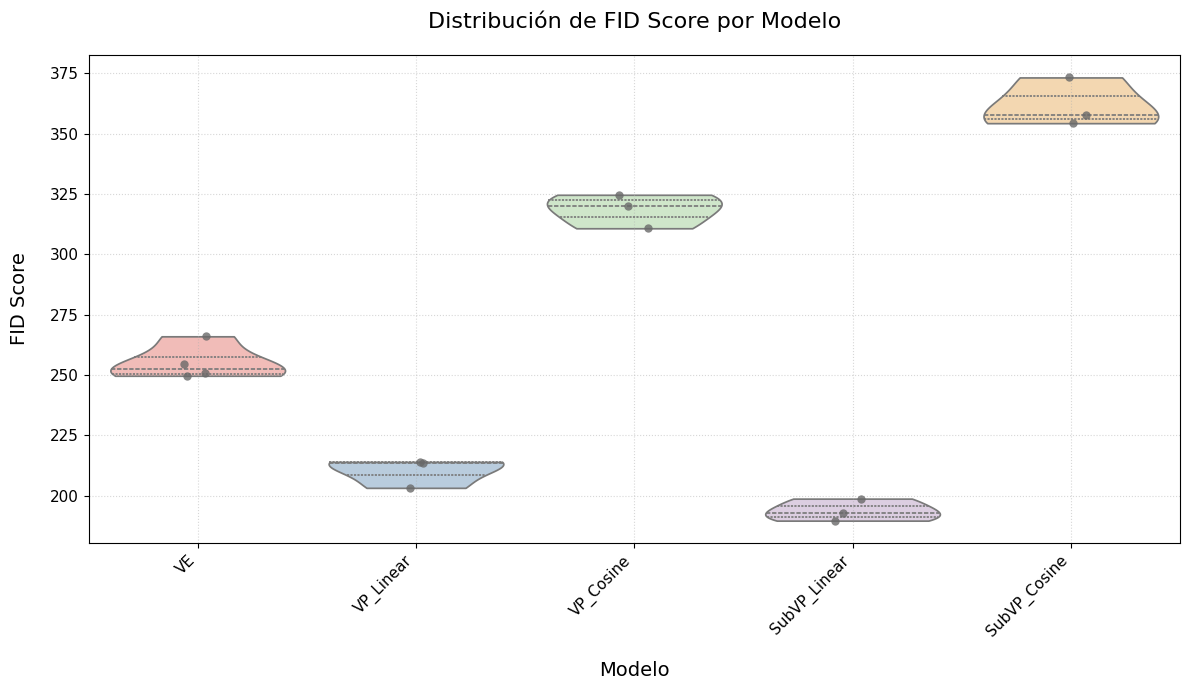

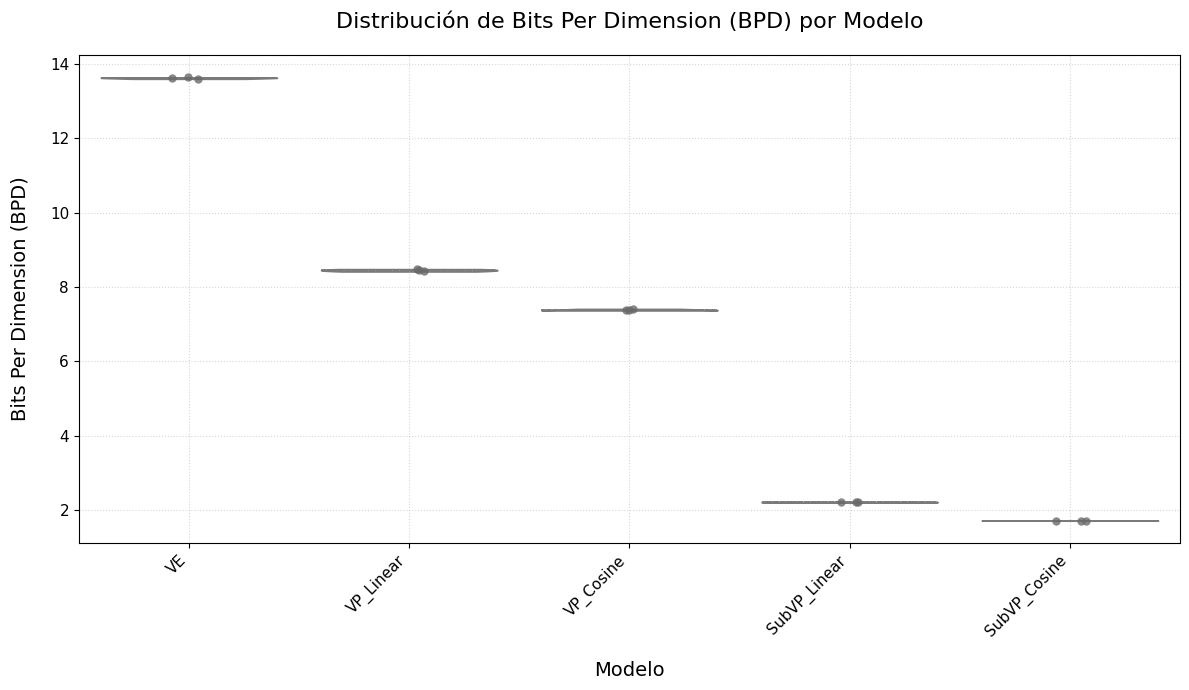

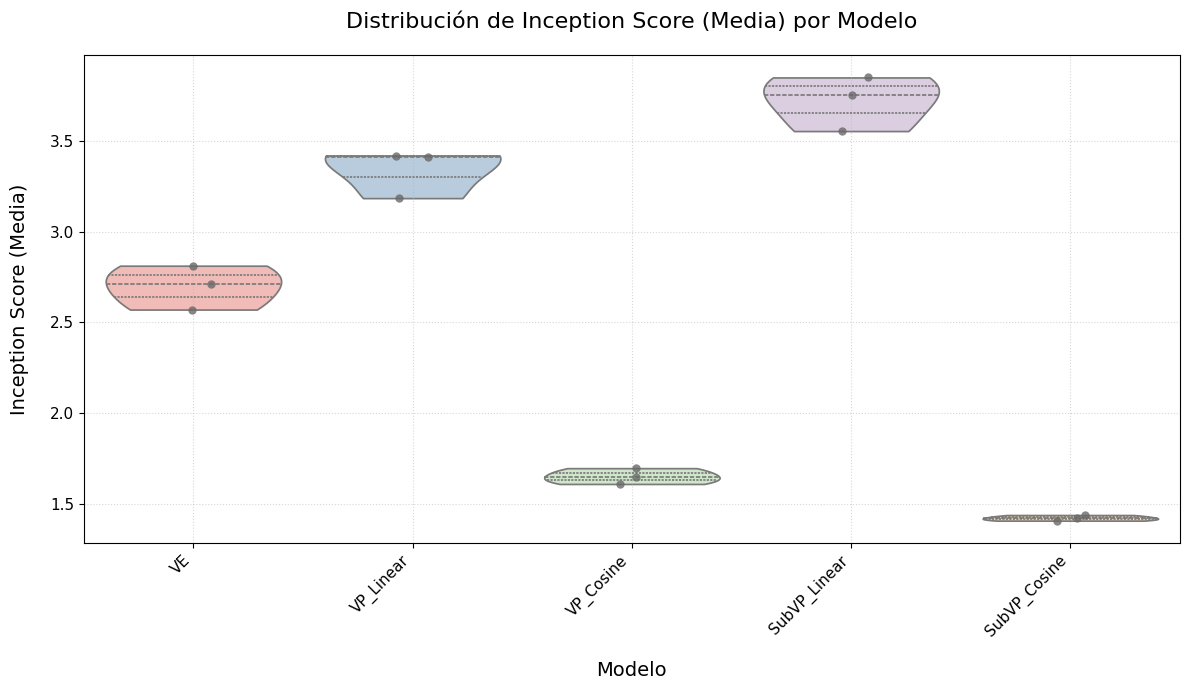

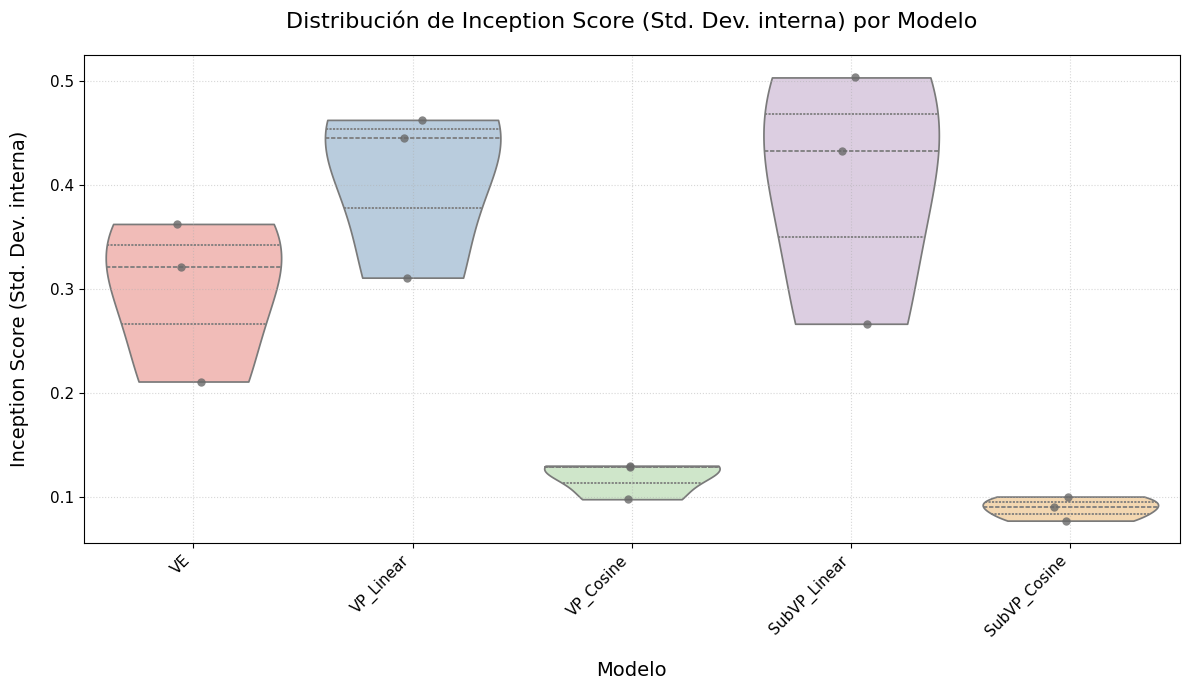

In [ ]:
import statistics # Para calcular media, mediana y desviación estándar
import pandas as pd # Para crear la tabla resumen
import matplotlib.pyplot as plt # Para gráficos
import seaborn as sns # Para gráficos más estéticos

lista_models = ['VE', 'VP_Linear', 'VP_Cosine', 'SubVP_Linear', 'SubVP_Cosine']

all_runs_results = {
    'VE': {
        'fid_scores': [250.6865, 249.7017, 254.6399, 266.0325],
        'bdp_scores': [13.6319, 13.6430, 13.6068],
        'mean_is_scores': [2.8125, 2.5706, 2.7104],
        'std_is_scores': [0.3625, 0.3211, 0.2111]
    },
    'VP_Linear': {
        'fid_scores': [213.9710, 213.6222, 203.2530],
        'bdp_scores': [8.4185, 8.4514, 8.4802],
        'mean_is_scores': [3.4131, 3.4200, 3.1851],
        'std_is_scores': [0.4451, 0.4625, 0.3109]
    },
    'VP_Cosine': {
        'fid_scores': [310.8002, 319.9435, 324.6781],
        'bdp_scores': [7.4086, 7.3756, 7.3689],
        'mean_is_scores': [1.6091, 1.6475, 1.6961],
        'std_is_scores': [0.0980, 0.1302, 0.1285]
    },
    'SubVP_Linear': {
        'fid_scores': [189.6672, 198.7822, 192.9997],
        'bdp_scores': [2.2068, 2.2059, 2.2050],
        'mean_is_scores': [3.8505, 3.5548, 3.7557],
        'std_is_scores': [0.5033, 0.2666, 0.4326]
    },
    'SubVP_Cosine': {
        'fid_scores': [357.5323, 373.2943, 354.3462],
        'bdp_scores': [1.7086, 1.7086, 1.7077],
        'mean_is_scores': [1.4197, 1.4068, 1.4377],
        'std_is_scores': [0.0909, 0.0774, 0.1005]
    }
}

# --- Calcular estadísticas (media, mediana y desviación estándar) ---
print("\n\n--- ESTADÍSTICAS DETALLADAS POR MODELO (BASADAS EN DATOS DEL LOG) ---")
final_summary_stats = {}

for model_name in lista_models: # Asegurar el orden
    scores_dict = all_runs_results.get(model_name, {})
    print(f"\nModelo: {model_name}")
    final_summary_stats[model_name] = {}

    metrics_to_process = {
        'FID': scores_dict.get('fid_scores', []),
        'BPD': scores_dict.get('bdp_scores', []), # Bits Per Dimension
        'Mean IS': scores_dict.get('mean_is_scores', []), # Inception Score (Media)
        'Std Dev IS (de IS)': scores_dict.get('std_is_scores', []) # Variabilidad interna de IS
    }

    for metric_name, scores in metrics_to_process.items():
        if scores:
            mean_val = statistics.mean(scores)
            median_val = statistics.median(scores)
            std_dev_val = statistics.stdev(scores) if len(scores) > 1 else float('nan')

            final_summary_stats[model_name][metric_name] = {
                'mean': mean_val,
                'median': median_val,
                'stdev': std_dev_val,
                'num_runs': len(scores),
                'all_runs': scores
            }
            print(f"  {metric_name}: (basado en {len(scores)} ejecuciones)")
            # print(f"    Todas las ejecuciones: {[float(f'{s:.4f}') for s in scores]}") # Descomentar para ver todos los valores
            print(f"    Media    : {mean_val:.4f}")
            print(f"    Mediana  : {median_val:.4f}")
            if not pd.isna(std_dev_val):
                print(f"    Std. Dev.: {std_dev_val:.4f}")
            else:
                print(f"    Std. Dev.: N/A (datos insuficientes)")
        else:
            print(f"  {metric_name}: No hay datos.")
            final_summary_stats[model_name][metric_name] = {
                'mean': float('nan'), 'median': float('nan'), 'stdev': float('nan'),
                'num_runs': 0, 'all_runs': []
            }

# --- Generación de Gráficos (Violin Plots) ---
print("\n\n--- GENERANDO GRÁFICOS DE VIOLÍN ---")
metrics_for_plotting = {
    'FID Score': 'FID',
    'Bits Per Dimension (BPD)': 'BPD',
    'Inception Score (Media)': 'Mean IS',
    'Inception Score (Std. Dev. interna)': 'Std Dev IS (de IS)'
}
# Preparar datos para plotting en formato largo
plot_data_list = []
for model_name, model_metrics_summary in final_summary_stats.items(): # Corregido para iterar sobre final_summary_stats
    for display_name, internal_key in metrics_for_plotting.items():
        if internal_key in model_metrics_summary and model_metrics_summary[internal_key]['all_runs']:
            for score in model_metrics_summary[internal_key]['all_runs']:
                plot_data_list.append({
                    'Modelo': model_name,
                    'Métrica': display_name,
                    'Valor': score
                })
df_plot = pd.DataFrame(plot_data_list)

# Crear un violin plot para cada métrica
for metric_display_name in metrics_for_plotting.keys():
    plt.figure(figsize=(12, 7)) # Ajustar tamaño para mejor visualización
    metric_subset_df = df_plot[df_plot['Métrica'] == metric_display_name]
    if not metric_subset_df.empty:
        # Violin plot
        sns.violinplot(x='Modelo', y='Valor', data=metric_subset_df, palette='Pastel1',
                       inner='quartile', # Muestra los cuartiles dentro del violín (alternativas: 'box', 'point', 'stick', None)
                       cut=0) # Evita que los violines se extiendan más allá de los datos extremos

        # Superponer puntos individuales para mayor claridad
        sns.stripplot(x='Modelo', y='Valor', data=metric_subset_df, color='dimgray', # Un color oscuro para los puntos
                      jitter=0.08, # Pequeña dispersión horizontal
                      size=6,      # Tamaño de los puntos
                      alpha=0.8)   # Transparencia de los puntos

        plt.title(f'Distribución de {metric_display_name} por Modelo', fontsize=16, pad=20)
        plt.ylabel(metric_display_name, fontsize=14, labelpad=15)
        plt.xlabel('Modelo', fontsize=14, labelpad=15)
        plt.xticks(rotation=45, ha="right", fontsize=11)
        plt.yticks(fontsize=11)
        plt.grid(True, linestyle=':', alpha=0.5) # Cuadrícula más sutil
        plt.tight_layout()

        filename_base = metric_display_name.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('.', '').replace('/', '_')
        filename = f"{filename_base}_violinplot.png"
        try:
            plt.savefig(filename, dpi=150)
            print(f"  Gráfico de violín guardado como: {filename}")
        except Exception as e:
            print(f"  Error al guardar el gráfico {filename}: {e}")

        # plt.show() # Descomentar si quieres que se muestren interactivamente
    else:
        print(f"  No hay datos suficientes para graficar {metric_display_name}.")

# --- Crear y mostrar la TABLA RESUMEN COMPACTA con Pandas ---
print("\n\n--- TABLA RESUMEN COMPACTA DE MÉTRICAS ---")

compact_table_data = []
for model_name in lista_models:
    model_stats = final_summary_stats.get(model_name, {})
    row = {'Modelo': model_name}

    for display_name, internal_key in metrics_for_plotting.items():
        stats = model_stats.get(internal_key, {})
        mean_val = stats.get('mean', float('nan'))
        stdev_val = stats.get('stdev', float('nan'))
        n_runs = stats.get('num_runs', 0)

        if n_runs > 0:
            mean_str = f"{mean_val:.2f}"
            if not pd.isna(stdev_val):
                stdev_str = f"{stdev_val:.2f}"
                row[display_name] = f"{mean_str} ± {stdev_str} (N={n_runs})"
            else:
                row[display_name] = f"{mean_str} (N={n_runs})"
        else:
            row[display_name] = "N/A"

    compact_table_data.append(row)

df_compact_summary = pd.DataFrame(compact_table_data)
# Asegurar el orden de columnas en la tabla final
df_compact_summary = df_compact_summary[['Modelo'] + list(metrics_for_plotting.keys())]


pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}' if pd.notnull(x) else 'NaN')

print(df_compact_summary.to_string(index=False))

print("\n\n--- FIN DEL SCRIPT ---")